In [1]:

from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import time
import numpy as np
from sklearn import metrics
import pandas as pd
import pprint

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import os

import pickle
import pretty_errors

### Dataset part

In [2]:
if os.path.abspath(os.getcwd()) != 'c:\\Users\\tdufl\\Documents\\WPC\\WPC_Python_driver_release':
    os.chdir("..")

Loads data_set, not forget to put Neutral to the non orientation dataset

In [3]:
alldfC1 = pd.read_csv('data_sensor/test_ori_V0_3s.csv')
alldfC2 = pd.read_csv('data_sensor/test_ori_V0_3s.csv')

alldfneutral= pd.read_csv('data_sensor/test_neutral.csv')
alldfneutral['Type'] = 'Neutral'

alldfacc = pd.read_csv('data_sensor/test_acc_C2_V0.csv')
alldfacc['Type'] = 'Neutral'


In [4]:
def perfect_concat(List_df):
    df = pd.DataFrame()
    def lil_concat(a,b):
        if a.empty:
            return b
        else:
            b['ID'] += a['ID'].max()
            b['index'] += a['index'].max() + 1
            return (pd.concat([a,b], axis = 0, ignore_index=True))
    for i in range(len(List_df)):
        df = lil_concat(df, List_df[i])
    return df

To prepare the dataset, just concat the list of the "littles" datasets

In [30]:
alldf = perfect_concat([alldfC1, alldfC2, alldfneutral, alldfacc])
alldf.shape

(44261, 11)

Remove the gravity part of the dataset

In [6]:

print(f" Max index : {alldf.index.max()}")
DEG_TO_RAD = np.pi / 180

alldf['X_acc'] = alldf['X_acc'] - 9.81* np.sin(DEG_TO_RAD * alldf['Pitch'])
alldf['Y_acc'] = alldf['Y_acc'] - 9.81 * np.sin(DEG_TO_RAD * alldf['Roll'])*np.cos(DEG_TO_RAD * alldf['Pitch'])
alldf['Z_acc'] = alldf['Z_acc'] - 9.81 * np.cos(DEG_TO_RAD * alldf['Roll'])*np.cos(DEG_TO_RAD * alldf['Pitch'])

all_data = alldf.copy()

 Max index : 44260


### Look on data

Compare number of measures by Type

[Text(0, 0, '10007'),
 Text(0, 0, '11102'),
 Text(0, 0, '10860'),
 Text(0, 0, '12292')]

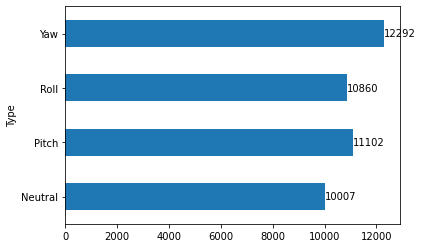

In [7]:
ax = nb_by_type = all_data.groupby('Type').index.nunique().plot.barh()
ax.bar_label(ax.containers[0])

Examine a simple correlation of the variables

In [8]:
data_corr = all_data.drop(['ID','Type','Time', 'index', 'Interval Time'], axis = 1).corr(method='pearson').round(2)
fig = px.imshow(data_corr, text_auto = True)  
#fig

We plot random curve to see if it's possible to recognize movement "with eyes"

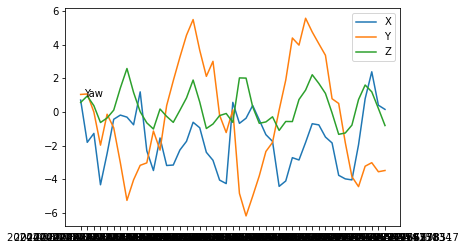

In [9]:
ID_plot = alldf['ID'].sample(n = 1)
ID_plot = ID_plot.iloc[0]
X = alldf[alldf['ID'] == ID_plot]['X_acc']
Y = alldf[alldf['ID'] == ID_plot]['Y_acc']
Z = alldf[alldf['ID'] == ID_plot]['Z_acc']
t = alldf[alldf['ID'] == ID_plot]['Time']
tlabel = alldf[alldf['ID'] == ID_plot]['Type'].iloc[0]

plt.plot(t,X, label = 'X')
plt.plot(t,Y, label = 'Y')
plt.plot(t,Z, label = 'Z')
plt.text(0.5, 0.9, f"{tlabel}" )
plt.legend()
plt.show()

#seems great

### Tabularize data

#### Data creation

In [10]:
length_tab = 7
n_id = alldf[alldf['Type'] == 'Roll'].ID.unique().shape[0]

In [11]:
columns = ['ID', 'Type', 'Interval Time', 'Time', 'index']
for i in range(length_tab):
    columns.append(f"X_acc_{i+1}")
    columns.append(f"Y_acc_{i+1}")
    columns.append(f"Z_acc_{i+1}")
    columns.append(f"Roll_{i+1}")
    columns.append(f"Pitch_{i+1}")
    columns.append(f"Yaw_{i+1}")
print(columns)
wide_tab = pd.DataFrame(columns = columns)

lil_tab = alldf.copy()

['ID', 'Type', 'Interval Time', 'Time', 'index', 'X_acc_1', 'Y_acc_1', 'Z_acc_1', 'Roll_1', 'Pitch_1', 'Yaw_1', 'X_acc_2', 'Y_acc_2', 'Z_acc_2', 'Roll_2', 'Pitch_2', 'Yaw_2', 'X_acc_3', 'Y_acc_3', 'Z_acc_3', 'Roll_3', 'Pitch_3', 'Yaw_3', 'X_acc_4', 'Y_acc_4', 'Z_acc_4', 'Roll_4', 'Pitch_4', 'Yaw_4', 'X_acc_5', 'Y_acc_5', 'Z_acc_5', 'Roll_5', 'Pitch_5', 'Yaw_5', 'X_acc_6', 'Y_acc_6', 'Z_acc_6', 'Roll_6', 'Pitch_6', 'Yaw_6', 'X_acc_7', 'Y_acc_7', 'Z_acc_7', 'Roll_7', 'Pitch_7', 'Yaw_7']


In [12]:
lil_tab = lil_tab.sort_values(by = ['ID', 'Time'], ascending = [True, True])
lil_tab['flipper'] = np.where(lil_tab.ID != lil_tab.ID.shift(1), 1, 0)

index_flipper = lil_tab[lil_tab['flipper'] == 1]
index_flipper = index_flipper[['ID', 'index']]
index_flipper.rename({'index' : 'index_start'}, axis = 1, inplace = True)
lil_tab0 = lil_tab.merge(index_flipper, on = 'ID', how = 'left')
lil_tab0['index_start'] = lil_tab0['index'] - lil_tab0['index_start'] #not +1 because I don't want to consider the 
#first value of each sample
lil_tab0['lets_tab'] = np.where((lil_tab0.index_start >= length_tab), 1, 0)

In [13]:
for i in range(length_tab):
    wide_tab[f"X_acc_{i+1}"] = lil_tab["X_acc"].shift(i)
    wide_tab[f"Y_acc_{i+1}"] = lil_tab["Y_acc"].shift(i)
    wide_tab[f"Z_acc_{i+1}"] = lil_tab["Z_acc"].shift(i)
    wide_tab[f"Roll_{i+1}"] = lil_tab["Roll"].shift(i)
    wide_tab[f"Pitch_{i+1}"] = lil_tab["Pitch"].shift(i)
    wide_tab[f"Yaw_{i+1}"] = lil_tab["Yaw"].shift(i)
    
wide_tab["ID"] = lil_tab["ID"]
wide_tab["Type"] = lil_tab["Type"]
wide_tab["Interval Time"] = lil_tab["Interval Time"]
wide_tab["Time"] = lil_tab["Time"]
wide_tab["index"] = lil_tab0["index_start"] - length_tab
wide_tab["lets_tab"] = lil_tab0["lets_tab"]
wide_tab = wide_tab[wide_tab["lets_tab"] == 1]

In [14]:
wide_tab_diff = wide_tab.copy()

wide_tab_diff['lets_diff'] = np.where(wide_tab_diff.ID != wide_tab_diff.ID.shift(1), 0, 1)
for i in range(length_tab):
    wide_tab_diff[f"X_acc_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'X_acc_{i+1}'], 0)
    wide_tab_diff[f"Y_acc_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Y_acc_{i+1}'], 0)
    wide_tab_diff[f"Z_acc_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Z_acc_{i+1}'], 0)
    wide_tab_diff[f"Roll_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Roll_{i+1}'].diff(), 0)
    wide_tab_diff[f"Pitch_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Pitch_{i+1}'].diff(), 0)
    wide_tab_diff[f"Yaw_{i+1}"] = np.where(wide_tab_diff['lets_diff'] == 1, wide_tab_diff[f'Yaw_{i+1}'].diff(), 0)

    wide_tab_diff.rename({f"Roll_{i+1}" : f"diff_Roll_{i+1}"}, axis = 1, inplace = True)
    wide_tab_diff.rename({f"Pitch_{i+1}" : f"diff_Pitch_{i+1}"}, axis = 1, inplace = True)
    wide_tab_diff.rename({f"Yaw_{i+1}" : f"diff_Yaw_{i+1}"}, axis = 1, inplace = True)
wide_tab_diff = wide_tab_diff[wide_tab_diff["lets_diff"] == 1]

In [15]:
wide_tab_diff2 = wide_tab_diff.copy()

wide_tab_diff2['lets_diff'] = np.where(wide_tab_diff2.ID != wide_tab_diff2.ID.shift(1), 0, 1)
for i in range(length_tab):
    wide_tab_diff2[f"diff_X_acc_{i+1}"] = np.where(wide_tab_diff2['lets_diff'] == 1, wide_tab_diff2[f'X_acc_{i+1}'].diff(), 0)
    wide_tab_diff2[f"diff_Y_acc_{i+1}"] = np.where(wide_tab_diff2['lets_diff'] == 1, wide_tab_diff2[f'Y_acc_{i+1}'].diff(), 0)
    wide_tab_diff2[f"diff_Z_acc_{i+1}"] = np.where(wide_tab_diff2['lets_diff'] == 1, wide_tab_diff2[f'Z_acc_{i+1}'].diff(), 0)
    wide_tab_diff2[f"diff_Roll_{i+1}"] = np.where(wide_tab_diff2['lets_diff'] == 1, wide_tab_diff2[f'diff_Roll_{i+1}'].diff(), 0)
    wide_tab_diff2[f"diff_Pitch_{i+1}"] = np.where(wide_tab_diff2['lets_diff'] == 1, wide_tab_diff2[f'diff_Pitch_{i+1}'].diff(), 0)
    wide_tab_diff2[f"diff_Yaw_{i+1}"] = np.where(wide_tab_diff2['lets_diff'] == 1, wide_tab_diff2[f'diff_Yaw_{i+1}'].diff(), 0)


    wide_tab_diff2.rename({f"X_acc_{i+1}" : f"diff_X_acc_{i+1}"}, axis = 1, inplace = True)
    wide_tab_diff2.rename({f"Y_acc_{i+1}" : f"diff_Y_acc_{i+1}"}, axis = 1, inplace = True)
    wide_tab_diff2.rename({f"Z_acc_{i+1}" : f"diff_Z_acc_{i+1}"}, axis = 1, inplace = True)
    wide_tab_diff2.rename({f"diff_Roll_{i+1}" : f"diff2_Roll_{i+1}"}, axis = 1, inplace = True)
    wide_tab_diff2.rename({f"diff_Pitch_{i+1}" : f"Pitch_diff2_{i+1}"}, axis = 1, inplace = True)
    wide_tab_diff2.rename({f"diff_Yaw_{i+1}" : f"diff2_Yaw_{i+1}"}, axis = 1, inplace = True)
    
wide_tab_diff2 = wide_tab_diff2[wide_tab_diff2["lets_diff"] == 1]

In [16]:
def get_split_train_test(dff = wide_tab):
    global df
    i = 0 
    while i == 0:
        ## Get a unique list of ID
        aa = wide_tab.copy()
        pd_id = aa.drop_duplicates(subset = 'ID', keep = 'first')
        pd_id = pd_id[['ID', 'Type']]

        ##Create random number between 0 and 1

        pd_id['boogie'] = (np.random.rand(len(pd_id)))
        pd_id['Modeling_Group'] = np.where(pd_id['boogie'] > 0.7, 'Test', 'Train')
        pd_id_pivot = pd_id.pivot_table(index = 'Type', columns = 'Modeling_Group', aggfunc = 'size')
        # pd_id_pivot['Roll']['Test']
        test_values = pd_id_pivot.loc[:]['Test']
        i = test_values[(test_values > (n_id//3)*0.8) & (test_values < (n_id //3) * 1.2)].shape[0] // 3

    pd_id = pd_id.drop(['Type'], axis = 1)
    X_data = pd.merge(dff, pd_id, on = 'ID', how = 'left')
    #print(X_data.head())
    X_train = X_data[X_data['Modeling_Group'] == 'Train']
    y_train = X_train['Type']
    X_train = X_train.drop(['Type','boogie', 'Modeling_Group', 'index', 'Interval Time', 'Time', 'lets_diff'], axis = 1, errors='ignore')

    X_test = X_data[X_data['Modeling_Group'] == 'Test']
    y_test = X_test['Type']
    X_test = X_test.drop(['Type', 'boogie', 'Modeling_Group', 'index', 'Interval Time', 'Time', 'lets_diff'], axis = 1, errors = 'ignore')

    return X_data, X_train, y_train, X_test, y_test



In [17]:
def evaluate_model_tab(alg, X_data, X_train, y_train, X_test, y_test, accuracy_return : bool = False, plot : bool = False, tree = False):
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    X_train = X_train.drop(['ID', 'lets_tab'], axis = 1)
    X_test = X_test.drop(['ID', 'lets_tab'], axis = 1)
    
    clf = alg.fit(X_train, y_train)
    #Predict training set:
    prediction = clf.predict(X_test)
    print(f"Confusion Matrix: \n{confusion_matrix(y_test, prediction)}")
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    y_test_ID['Prediction'] = prediction
    Y_result = y_test_ID.groupby('ID').agg(lambda x: pd.Series.mode(x)[0])
    if plot and tree:
        feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)[:15]
        feat_imp.plot.bar()
        plt.ylabel('Feature Importance Score')
        plt.show()
    score = round(clf.score(X_test, y_test),2)
    print(f"Dumb Accuracy: {score}")
    print(f"Adapted Accuracy: {accuracy_score(Y_result['Type'], Y_result['Prediction']):.2f}")
    if accuracy_return:
        return round(accuracy_score(Y_result['Type'], Y_result['Prediction']),2)
    return clf, score

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN

random_state = 99
knn = KNN()
dtc = DecisionTreeClassifier(random_state = 99)
clf = RandomForestClassifier(n_estimators = 1, random_state = 99)
## essayer avec Naive Bayes, KNN, and Logistic Regresssion
X_data, X_train, y_train, X_test, y_test = get_split_train_test(wide_tab_diff)
rf_tab_micro, score = evaluate_model_tab(knn, X_data, X_train, y_train, X_test, y_test, accuracy_return=False, plot = False)

Confusion Matrix: 
[[1341  111   19   35]
 [  59 2462   92   34]
 [   2  157 2665   57]
 [   6   56   53 3138]]
Dumb Accuracy: 0.93
Adapted Accuracy: 0.97


In [19]:
score

0.93

In [20]:
# print(rf_tab_micro.to_micropython())

95 % sans prendre en compte neutral vs 85 % le prenant en compte, 
 
adapted accuracy goes from 99% to 95%

In [21]:
# with open('classifiers/clf_acc_0g_neutralpos.pkl', 'wb') as file:
#       pickle.dump(rf_tab, file)

In [22]:
wide_tab_classic = wide_tab_diff.copy()
y_c = wide_tab_classic['Type']
wide_tab_classic = wide_tab_classic.drop(['Type', 'ID', 'Time', 'Interval Time', 'index', 'lets_tab', 'lets_diff'], axis = 1)

In [23]:
wide_tab_classic.shape

(32553, 42)

In [24]:
from sklearn.model_selection import train_test_split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(wide_tab_classic, y_c, test_size=0.2, random_state=42)

In [25]:
X_train_c.head(20)

,X_acc_1,Y_acc_1,Z_acc_1,diff_Roll_1,diff_Pitch_1,diff_Yaw_1,X_acc_2,Y_acc_2,Z_acc_2,diff_Roll_2,...,Z_acc_6,diff_Roll_6,diff_Pitch_6,diff_Yaw_6,X_acc_7,Y_acc_7,Z_acc_7,diff_Roll_7,diff_Pitch_7,diff_Yaw_7
6836,-0.905166,-0.994244,0.010918,0.1180,-1.0351,6.4775,0.508007,0.307343,0.253068,0.2941,...,0.185389,0.2792,-0.8142,7.1568,0.238191,-0.298026,0.411036,-0.1548,-1.8843,6.8884
14986,-0.039518,-0.122702,-0.590802,49.9252,-1.9334,33.4720,-0.494125,0.855510,0.207601,45.9198,...,5.359444,0.6225,0.2904,2.5586,0.389613,0.093869,2.233206,-4.7664,-0.6183,5.1444
25621,0.436004,-1.017926,-0.276062,0.0492,2.4542,-5.9707,0.078211,-0.812877,0.552026,0.0623,...,-0.566188,2.3587,-1.1523,-4.3658,0.537958,-0.306812,0.424383,1.6439,-0.0288,-1.6699
43628,0.080442,0.093192,2.508915,-19.6517,-1.4012,19.6231,0.575712,-0.585744,0.891565,-14.1504,...,-3.305878,1.5507,1.1666,0.2109,0.201299,0.631277,-4.101353,-0.2297,0.8443,1.5723
27576,-0.171753,0.086369,0.048521,-18.0560,-0.6420,1.3620,-0.143325,-0.400259,1.465589,-25.7911,...,1.374707,1.6483,1.2360,-0.3280,0.838169,-0.443877,-0.654648,12.4947,2.8299,2.0113
6769,-0.318292,0.201132,-0.225965,0.4436,0.3578,-3.8473,0.451627,0.150504,0.542702,-0.2573,...,-1.627438,0.6986,0.6225,-3.3699,0.118316,-0.517279,0.582104,0.6245,-1.2893,-3.7508
31990,2.112233,2.630864,2.528260,-17.6189,-1.5838,-3.2713,-0.600209,-1.504617,-0.401094,-15.3080,...,-2.366469,33.6130,2.2745,23.0929,-0.645035,-1.549289,-0.969474,19.6153,2.1973,5.9151
28677,0.192619,-0.580185,0.266855,-1.2991,0.3516,-6.2819,-0.872921,-0.295572,0.910727,-3.4958,...,0.344872,-0.7563,0.7071,-4.0076,-0.874318,-0.133324,0.970750,-0.9573,1.5873,-3.3789
41198,0.255910,0.976162,0.485126,-336.0055,-0.0787,-23.5904,-0.751157,-0.009640,-0.577006,17.3758,...,-1.109306,-8.0710,-0.0271,11.5008,-2.170535,0.636765,1.340449,-5.9519,0.4075,6.9304
26090,0.875452,0.026240,0.588334,0.6619,6.4722,0.2765,0.236003,0.466569,0.493616,0.4534,...,0.896630,16.1992,10.4771,-19.0450,1.028284,-0.121659,0.441592,128.3440,-1.0940,230.5552


In [26]:
X_train_c.columns

Index(['X_acc_1', 'Y_acc_1', 'Z_acc_1', 'diff_Roll_1', 'diff_Pitch_1',
       'diff_Yaw_1', 'X_acc_2', 'Y_acc_2', 'Z_acc_2', 'diff_Roll_2',
       'diff_Pitch_2', 'diff_Yaw_2', 'X_acc_3', 'Y_acc_3', 'Z_acc_3',
       'diff_Roll_3', 'diff_Pitch_3', 'diff_Yaw_3', 'X_acc_4', 'Y_acc_4',
       'Z_acc_4', 'diff_Roll_4', 'diff_Pitch_4', 'diff_Yaw_4', 'X_acc_5',
       'Y_acc_5', 'Z_acc_5', 'diff_Roll_5', 'diff_Pitch_5', 'diff_Yaw_5',
       'X_acc_6', 'Y_acc_6', 'Z_acc_6', 'diff_Roll_6', 'diff_Pitch_6',
       'diff_Yaw_6', 'X_acc_7', 'Y_acc_7', 'Z_acc_7', 'diff_Roll_7',
       'diff_Pitch_7', 'diff_Yaw_7'],
      dtype='object')

Avec un "dumb" test train split, on a près de 87% d'accuracy for decision tree and for Knn

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
knn_model = knn.fit(X_train_c, y_train_c)
dt_model = dt.fit(X_train_c,y_train_c)
y_pred_knn = knn.predict(X_test_c)
y_pred_dt = dt.predict(X_test_c)
# Calculer les métriques d'évaluation
accuracy_knn = accuracy_score(y_test_c, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test_c, y_pred_knn)
classification_report_knn = classification_report(y_test_c, y_pred_knn)

accuracy_dt = accuracy_score(y_test_c, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test_c, y_pred_dt)
classification_report_dt = classification_report(y_test_c, y_pred_dt)

print('Accuracy Knn:', accuracy_knn)
print('Confusion Matrix Knn:\n', conf_matrix_knn)
print('Classification Report Knn:\n', classification_report_knn)

print('Accuracy Dt:', accuracy_dt)
print('Confusion Matrix Dt:\n', conf_matrix_dt)
print('Classification Report Dt:\n', classification_report_dt)

Accuracy Knn: 0.9487021962832131
Confusion Matrix Knn:
 [[ 827   58   15   22]
 [  22 1716   60   29]
 [   2   39 1673   25]
 [  12   30   20 1961]]
Classification Report Knn:
               precision    recall  f1-score   support

     Neutral       0.96      0.90      0.93       922
       Pitch       0.93      0.94      0.94      1827
        Roll       0.95      0.96      0.95      1739
         Yaw       0.96      0.97      0.97      2023

    accuracy                           0.95      6511
   macro avg       0.95      0.94      0.95      6511
weighted avg       0.95      0.95      0.95      6511

Accuracy Dt: 0.9608355091383812
Confusion Matrix Dt:
 [[ 789   23   52   58]
 [   6 1801    6   14]
 [  12    6 1705   16]
 [  34   14   14 1961]]
Classification Report Dt:
               precision    recall  f1-score   support

     Neutral       0.94      0.86      0.90       922
       Pitch       0.98      0.99      0.98      1827
        Roll       0.96      0.98      0.97      17

In [28]:
# import pickle
# with open("classifiers/clf_ori_V3.pkl", 'wb') as file:
#     pickle.dump(dt_model, file)
    

In [29]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mapping = {'X_acc' : 0, 'Y_acc' : 1, 'Z_acc' : 2, 'Neutral' : 3}
    
def to_int(l):
    return [mapping[i] for i in l]

#split dataset in features and target variable
X_ai, y_ai = wide_tab_classic.copy(), y_c.copy()
X_ai, y_ai = X_ai.values, y_ai.values
y_ai = to_int(y_ai)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_ai_t = scaler.fit_transform(X_ai)
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train_ai ,X_test_ai ,y_train_ai ,y_test_ai =train_test_split(X_ai_t,y_ai,test_size=0.1,random_state=0)
# We'll use Keras to create a Neural network

print(type(X_test_ai))

KeyError: 'Roll'

Epoch 1/10


351/351 ━━━━━━━━━━━━━━━━━━━━ 4:04 697ms/step - accuracy: 0.1562 - loss: 1.79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1869 - loss: 1.7765   ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2034 - loss: 1.73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2157 - loss: 1.71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2236 - loss: 1.69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2322 - loss: 1.67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2398 - loss: 1.65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2470 - loss: 1.64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2556 - loss: 1.62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2615 - loss: 1.61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2623 - loss: 1.61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2647 - loss: 1.60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2702 - loss: 1.59 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2765 - loss: 1.5832 - val_accuracy: 0.4755 - val_loss: 1.2779
Epoch 2/10
351/351 ━━━━━━━━━━━

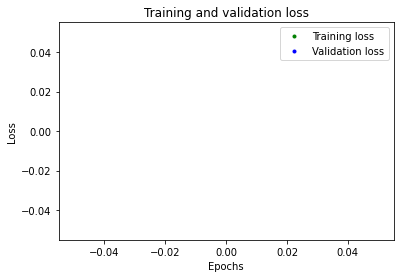

[array([[-8.95850003e-01, -6.85993671e-01,  1.85919348e-02,
        -7.77356774e-02,  1.98931433e-04,  1.08594334e+00,
         3.26123208e-01,  7.12071871e-03],
       [-3.22915684e-03,  1.98008213e-02,  1.77154273e-01,
         9.70377475e-02,  2.11673621e-02,  6.44628182e-02,
         6.16341345e-02,  3.26501764e-02],
       [ 1.15919672e-01, -4.44450416e-02,  5.29123582e-02,
         1.32489741e+00, -1.02809334e+00, -1.19345123e-02,
         4.52545956e-02,  2.75664926e-01],
       [ 7.10259005e-02, -1.22141756e-01,  2.36114264e-02,
        -2.55679060e-03,  1.28834033e-02,  8.91597196e-03,
         2.97533184e-01, -6.01713806e-02],
       [-1.25946939e-01,  1.13633148e-01, -1.73975918e-02,
        -5.98877901e-03, -2.64276098e-02, -4.24071550e-02,
        -6.75263852e-02,  7.94717968e-02],
       [ 9.77148041e-02, -2.47191880e-02,  1.45481611e-02,
         4.16541956e-02,  2.99108904e-02,  5.20620756e-02,
         1.87569052e-01,  5.48700355e-02],
       [-9.46525812e-01, -3.74476

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mapping = {'X_acc' : 0, 'Y_acc' : 1, 'Z_acc' : 2, 'Neutral' : 3}
    
def to_int(l):
    return [mapping[i] for i in l]

#split dataset in features and target variable
X_ai, y_ai = wide_tab_classic.copy(), y_c.copy()
X_ai, y_ai = np.array(X_ai.to_numpy()), np.array(y_ai.to_numpy())
y_ai = np.array(to_int(y_ai))
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# X_ai_t = scaler.fit_transform(X_ai)
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train_ai ,X_test_ai ,y_train_ai ,y_test_ai =train_test_split(X_ai_t,y_ai,test_size=0.1,random_state=0)
# We'll use Keras to create a Neural network
model = tf.keras.Sequential()
model = tf.keras.Sequential([
    tf.keras.Input(shape=(42,)),
    keras.layers.Dense(8, activation='relu'),
    # keras.layers.Dense(8,activation='relu'),
    keras.layers.Dense(4,activation='softmax',
                           )
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
##10 epochs only to avoid losing to much time when running the whole jupyter, 100 in normal time
history_1 = model.fit(X_train_ai, y_train_ai, epochs=10, validation_data=(X_test_ai, y_test_ai))
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto'
)

# Exclude the first few epochs so the graph is easier to read
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)
SKIP = 10
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Find the weights of the model
weights = model.get_weights()
print(weights)
# Saving the array in a text file
file = open("hyper_param.txt", "w+")
content = str(weights)
file.write(content)
file.close()
y_pred = model.predict(X_test_ai)
# extract the predicted probabilities
p_pred = model.predict(X_test_ai)
p_pred = p_pred.flatten()
print(p_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# extract the predictedch class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)
# import the metrics class
from sklearn import metrics
# cnf_matrix = metrics.confusion_matrix(y_test_ai, y_pred)
# cnf_matrix

### Rolling Windows

In [ ]:
X = alldf.copy()

feature_window = 7

In [ ]:
def add_parameters(X):   
    def add_lets_diff(X):
        X['lets_diff'] = np.where(X.ID != X.ID.shift(1), 0, 1)
        return X
    X = add_lets_diff(X)

    def add_derivative(X):
        X['roll_diff'] = np.where(X['lets_diff'] == 1, X['Roll'].diff(), 0)
        X['pitch_diff'] = np.where(X['lets_diff'] == 1, X['Pitch'].diff(), 0)
        X['yaw_diff'] = np.where(X['lets_diff'] == 1, X['Yaw'].diff(), 0)
        return X
    X = add_derivative(X)
    #Second Derivative then

    X_sd = X.copy()
    #we check where it is possible to add second differentiate
    X_sd = X_sd[X_sd['lets_diff'] == 1]
    X_sd['lets_diff2'] = np.where(X_sd.ID != X_sd.ID.shift(1), 0, 1)

    #second differentiate
    X_sd['roll_diff2'] = np.where(X_sd['lets_diff2'] == 1, X_sd['roll_diff'].diff(), 0)
    X_sd['pitch_diff2'] = np.where(X_sd['lets_diff2'] == 1, X_sd['pitch_diff'].diff(), 0)
    X_sd['yaw_diff2'] = np.where(X_sd['lets_diff2'] == 1, X_sd['yaw_diff'].diff(), 0)

    X_sd = X_sd[X_sd['lets_diff2'] == 1]

    X_sd = X_sd.drop(['lets_diff', 'lets_diff2'], axis = 1)

    df_rw = X_sd.copy()
    df_rw = df_rw.sort_values(by = ['ID', 'Time'], ascending = [True, True])
    df_rw['flipper'] = np.where(df_rw.ID != df_rw.ID.shift(1), 1, 0)
    return(df_rw)

In [ ]:
def lets_roll_add(df_rw):  
    index_flipper = df_rw[df_rw['flipper'] == 1]
    index_flipper = index_flipper[['ID', 'index']]
    index_flipper.rename({'index': 'index_start'}, axis = 1, inplace = True)
    df_rw0 = df_rw.merge(index_flipper, on = 'ID', how = 'left')
    df_rw0['index'] = df_rw0['index'] - df_rw0['index_start'] + 1 # +1 to set index from 1 to max index (and not 0 to max index -1)
    df_rw0.rename({'index' : 'ID_sample'}, axis = 1, inplace = True)
    df_rw.rename({'index' : 'ID_sample'}, axis = 1, inplace = True)
    df_rw0['lets_roll'] = np.where((df_rw.ID_sample >= feature_window +2), 1, 0) # +2 because we have the second derivative

    return(df_rw0)

In [ ]:
def add_columns(X):
    X = add_parameters(X)
    df_rw0 = lets_roll_add(X)
    df_rw0['Roll_mean'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Roll'].rolling(window = feature_window).mean()), 0)
    df_rw0['Roll_std'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Roll'].rolling(window = feature_window).std()), 0)
    df_rw0['Roll_min'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Roll'].rolling(window = feature_window).min()), 0)
    df_rw0['Roll_max'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Roll'].rolling(window = feature_window).max()), 0)
    df_rw0['Roll_median'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Roll'].rolling(window = feature_window).median()), 0)
    df_rw0['Roll_skew'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Roll'].rolling(window = feature_window).skew()), 0)

    df_rw0['Pitch_mean'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Pitch'].rolling(window = feature_window).mean()), 0)
    df_rw0['Pitch_std'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Pitch'].rolling(window = feature_window).std()), 0)
    df_rw0['Pitch_min'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Pitch'].rolling(window = feature_window).min()), 0)
    df_rw0['Pitch_max'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Pitch'].rolling(window = feature_window).max()), 0)
    df_rw0['Pitch_median'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Pitch'].rolling(window = feature_window).median()), 0)
    df_rw0['Pitch_skew'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Pitch'].rolling(window = feature_window).skew()), 0)

    df_rw0['Yaw_mean'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Yaw'].rolling(window = feature_window).mean()), 0)
    df_rw0['Yaw_std'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Yaw'].rolling(window = feature_window).std()), 0)
    df_rw0['Yaw_min'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Yaw'].rolling(window = feature_window).min()), 0)
    df_rw0['Yaw_max'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Yaw'].rolling(window = feature_window).max()), 0)
    df_rw0['Yaw_median'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Yaw'].rolling(window = feature_window).median()), 0)
    df_rw0['Yaw_skew'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['Yaw'].rolling(window = feature_window).skew()), 0)


    #diff1 part
    df_rw0['Roll_diff_mean'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff'].rolling(window = feature_window).mean()), 0)
    df_rw0['Roll_diff_std'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff'].rolling(window = feature_window).std()), 0)
    df_rw0['Roll_diff_min'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff'].rolling(window = feature_window).min()), 0)
    df_rw0['Roll_diff_max'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff'].rolling(window = feature_window).max()), 0)
    df_rw0['Roll_diff_median'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff'].rolling(window = feature_window).median()), 0)
    df_rw0['Roll_diff_skew'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff'].rolling(window = feature_window).skew()), 0)

    df_rw0['Pitch_diff_mean'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff'].rolling(window = feature_window).mean()), 0)
    df_rw0['Pitch_diff_std'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff'].rolling(window = feature_window).std()), 0)
    df_rw0['Pitch_diff_min'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff'].rolling(window = feature_window).min()), 0)
    df_rw0['Pitch_diff_max'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff'].rolling(window = feature_window).max()), 0)
    df_rw0['Pitch_diff_median'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff'].rolling(window = feature_window).median()), 0)
    df_rw0['Pitch_diff_skew'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff'].rolling(window = feature_window).skew()), 0)

    df_rw0['Yaw_diff_mean'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff'].rolling(window = feature_window).mean()), 0)
    df_rw0['Yaw_diff_std'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff'].rolling(window = feature_window).std()), 0)
    df_rw0['Yaw_diff_min'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff'].rolling(window = feature_window).min()), 0)
    df_rw0['Yaw_diff_max'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff'].rolling(window = feature_window).max()), 0)
    df_rw0['Yaw_diff_median'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff'].rolling(window = feature_window).median()), 0)
    df_rw0['Yaw_diff_skew'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff'].rolling(window = feature_window).skew()), 0)


    #diff2 part
    df_rw0['Roll_diff2_mean'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff2'].rolling(window = feature_window).mean()), 0)
    df_rw0['Roll_diff2_std'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff2'].rolling(window = feature_window).std()), 0)
    df_rw0['Roll_diff2_min'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff2'].rolling(window = feature_window).min()), 0)
    df_rw0['Roll_diff2_max'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff2'].rolling(window = feature_window).max()), 0)
    df_rw0['Roll_diff2_median'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff2'].rolling(window = feature_window).median()), 0)
    df_rw0['Roll_diff2_skew'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['roll_diff2'].rolling(window = feature_window).skew()), 0)

    df_rw0['Pitch_diff2_mean'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff2'].rolling(window = feature_window).mean()), 0)
    df_rw0['Pitch_diff2_std'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff2'].rolling(window = feature_window).std()), 0)
    df_rw0['Pitch_diff2_min'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff2'].rolling(window = feature_window).min()), 0)
    df_rw0['Pitch_diff2_max'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff2'].rolling(window = feature_window).max()), 0)
    df_rw0['Pitch_diff2_median'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff2'].rolling(window = feature_window).median()), 0)
    df_rw0['Pitch_diff2_skew'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['pitch_diff2'].rolling(window = feature_window).skew()), 0)

    df_rw0['Yaw_diff2_mean'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff2'].rolling(window = feature_window).mean()), 0)
    df_rw0['Yaw_diff2_std'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff2'].rolling(window = feature_window).std()), 0)
    df_rw0['Yaw_diff2_min'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff2'].rolling(window = feature_window).min()), 0)
    df_rw0['Yaw_diff2_max'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff2'].rolling(window = feature_window).max()), 0)
    df_rw0['Yaw_diff2_median'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff2'].rolling(window = feature_window).median()), 0)
    df_rw0['Yaw_diff2_skew'] = np.where((df_rw0['lets_roll'] == 1), (df_rw0['yaw_diff2'].rolling(window = feature_window).skew()), 0)
    df_rw0 = df_rw0[df_rw0['lets_roll'] == 1]

    return(df_rw0)

In [ ]:
def get_split_train_test(X):
    dff = add_columns(X)
    global alldf
    i = 0 
    while i == 0:
        ## Get a unique list of ID
        aa = alldf.copy()
        pd_id = aa.drop_duplicates(subset = 'ID', keep = 'first')
        pd_id = pd_id[['ID', 'Type']]

        ##Create random number between 0 and 1

        pd_id['boogie'] = (np.random.rand(len(pd_id)))
        pd_id['Modeling_Group'] = np.where(pd_id['boogie'] > 0.7, 'Test', 'Train')
        pd_id_pivot = pd_id.pivot_table(index = 'Type', columns = 'Modeling_Group', aggfunc = 'size')
        # pd_id_pivot['Roll']['Test']
        test_values = pd_id_pivot.loc[:]['Test']
        i = test_values[(test_values > (n_id//3) * 0.9) & (test_values < (n_id//3) * 1.1)].shape[0] // 3

    pd_id = pd_id.drop(['Type'], axis = 1)
    X_data = pd.merge(dff, pd_id, on = 'ID', how = 'left')
    #print(X_data.head())
    X_train = X_data[X_data['Modeling_Group'] == 'Train']
    y_train = X_train['Type']
    X_train = X_train.drop(['Type','boogie', 'Modeling_Group', 'ID_sample', 'Interval Time', 'Time', 'index_start'], axis = 1)

    X_test = X_data[X_data['Modeling_Group'] == 'Test']
    y_test = X_test['Type']
    X_test = X_test.drop(['Type', 'boogie', 'Modeling_Group', 'ID_sample', 'Interval Time', 'Time', 'index_start'], axis = 1)
    return X_data, X_train, y_train, X_test, y_test

X_data, X_train, y_train, X_test, y_test = get_split_train_test(X)
print(X_train.columns)

Index(['ID', 'Roll', 'Pitch', 'Yaw', 'X_acc', 'Y_acc', 'Z_acc', 'roll_diff',
       'pitch_diff', 'yaw_diff', 'roll_diff2', 'pitch_diff2', 'yaw_diff2',
       'flipper', 'lets_roll', 'Roll_mean', 'Roll_std', 'Roll_min', 'Roll_max',
       'Roll_median', 'Roll_skew', 'Pitch_mean', 'Pitch_std', 'Pitch_min',
       'Pitch_max', 'Pitch_median', 'Pitch_skew', 'Yaw_mean', 'Yaw_std',
       'Yaw_min', 'Yaw_max', 'Yaw_median', 'Yaw_skew', 'Roll_diff_mean',
       'Roll_diff_std', 'Roll_diff_min', 'Roll_diff_max', 'Roll_diff_median',
       'Roll_diff_skew', 'Pitch_diff_mean', 'Pitch_diff_std', 'Pitch_diff_min',
       'Pitch_diff_max', 'Pitch_diff_median', 'Pitch_diff_skew',
       'Yaw_diff_mean', 'Yaw_diff_std', 'Yaw_diff_min', 'Yaw_diff_max',
       'Yaw_diff_median', 'Yaw_diff_skew', 'Roll_diff2_mean', 'Roll_diff2_std',
       'Roll_diff2_min', 'Roll_diff2_max', 'Roll_diff2_median',
       'Roll_diff2_skew', 'Pitch_diff2_mean', 'Pitch_diff2_std',
       'Pitch_diff2_min', 'Pitch_diff2_max'

In [ ]:
def evaluate_model_tab(alg, X, accuracy_return : bool = False, plot : bool = False):
    X_data, X_train, y_train, X_test, y_test = get_split_train_test(X)
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    X_train = X_train.drop(['ID'], axis = 1)
    X_test = X_test.drop(['ID'], axis = 1)
    
    clf = alg.fit(X_train, y_train)
    #Predict training set:
    prediction = clf.predict(X_test)
    print(f"Confusion Matrix: \n{confusion_matrix(y_test, prediction)}")
    y_test_ID = X_data[X_data['Modeling_Group'] == 'Test'][['ID', 'Type']]
    y_test_ID['Prediction'] = prediction
    Y_result = y_test_ID.groupby('ID').agg(lambda x: pd.Series.mode(x)[0])
    feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)[:15]
    if plot:
        feat_imp.plot.bar()
        plt.ylabel('Feature Importance Score')
        plt.show()
    print(f"Dumb Accuracy: {clf.score(X_test, y_test):.2f}")
    #print(f"Dumb F1 Score: {f1_score(y_test, prediction, average = 'weighted'):.2f}")
    print(f"Adapted Accuracy: {accuracy_score(Y_result['Type'], Y_result['Prediction']):.2f}")
    if accuracy_return:
        return round(accuracy_score(Y_result['Type'], Y_result['Prediction']),2)
    return clf

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, max_depth = 5, random_state = 42)
clf = DecisionTreeClassifier()
## essayer avec Naive Bayes, KNN, and Logistic Regresssion
X_test = alldf.copy()
rf = evaluate_model_tab(clf, X_test, accuracy_return=True, plot = False)

Confusion Matrix: 
[[1200   61   30   45]
 [  56 1515  192  175]
 [  24  229 1412  231]
 [  30  162  177 1459]]
Dumb Accuracy: 0.80
Adapted Accuracy: 0.97
